In [2]:
import gensim
from gensim.utils import simple_preprocess

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.corpus import stopwords

import re
import string
import seaborn as sns
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

nlp = spacy.load("en_core_web_sm")
stops_nltk = set(stopwords.words("english"))
stops_spacy = STOP_WORDS.union({'ll', 've', 'pron','okay','oh','like','know','yeah','yea','yep',\
                                "like like","oh like","yeah like","yeah yeah","oh okay","wow","podcast",\
                               "support","anchor","podcasts","episode","http","https","5star","reviews",\
                               "review","instagram","tiktok","amazon","apple","twitter","goole",\
                               "facebook","send","voice message","message","voice","subscribe","follow",\
                               "sponsor","links","easiest","way","fuck","fucking"})
stops = stops_nltk.union(stops_spacy)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [3]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import math
global df, show_descriptions

meta_data = []
with open("../data/metadata.tsv") as csvfile:
    csvreader = csv.reader(csvfile,delimiter="\t")
    for row in csvreader:
        meta_data.append(row)

df = pd.DataFrame(meta_data[1:],columns=meta_data[0])

In [4]:
genres_topics = ["comedy","news","crime","science","economics","politics","education",\
                  "sports","lifestyle","health","wellbeing","religion","faith","music",\
                  "art","fashion","literature","humanities","drama","fitness","drama",\
                  "fantasy","scifi","gameshow","news quiz","games","mental",\
                  "humor","research","technology","society","social","culture","lifestyle",\
                  "songs","cooking","culinary","food","travel","films","film","movies","tv",\
                  "climate","space","planet","digital","artificial intelligence", "ai",\
                  "cars","car","nutrition","wellness","family","history","geography","physics",\
                  "mathematics","math","chemistry","biology","documentary","commentary","nfl",\
                  "mls","nba","mlb","stocks","stock","market","wall","street","business",\
                  "reality","shows","investing","social media","biography","biographies",\
                  "data science","medicine","media","books","book","europe","asia","canada",\
                  "south america","north america","america","usa","netflix","adventure","pets","dogs",\
                  "cats","dog","cat","nintendo","xbox","playstation","ps4","ps5","theatre","mars"\
                  "tennis","australia","conspiracy","war","epidemic","pandemic","climate","change"\
                  "astrology","novel","church","christ","romance","english","kids","astronomy"\
                  "design","entrepreneurship","marketing","digital"]

formats = ["monologue","interview","storytelling","repurposed",\
           "bite-sized","co-host conversation","debate","narrative",\
           "scripted","improvised"]

In [5]:
# Cleaning & remove urls and links
def remove_stops(text,stops):
    final = []
    for word in text:
        if word not in stops and len(word) > 3:
            final.append(word)
    final = " ".join([item for item in final if not item.isdigit() and item!=''])
    while "  " in final:
        final = final.replace("  "," ")
    return final
                       
def clean_descriptions(docs):
    final = []
    for doc in docs:
        clean_doc = remove_stops(doc, stops)
        final.append(clean_doc)
    return final

# lemmatization -- do lemmatization for just the verbs
def get_lemmatized(text):
    lemmatized = []
    for phrase in text:
        sentence=''
        for word in nlp(phrase):
            if word.pos_ == "VERB":
                #or word.pos_ == "ADJ" or word.pos_ == "ADV":
                sentence += ' ' + str(word.lemma_)
            elif str(word)!='':
                sentence += ' ' + str(word)
        lemmatized.append(sentence.strip())
    return lemmatized

def get_named_entities(text):
    return nlp(text.lower()).ents

def get_noun_chunks(text):
    non_stop_noun_chunks = []
    stops = stopwords.words("english")
    for word in nlp(text.lower()).noun_chunks:
        if str(word) not in stops:
            non_stop_noun_chunks.append(word)
    return non_stop_noun_chunks

#### load genres and topics collected using show names

In [ ]:
# with open("show_names_genres_topics.txt","r") as f:
#     lines = f.readlines()

In [ ]:
# podcasts_genres_topics = {}
# for line in lines:
#     l = line.strip().split(",")
#     podcasts_genres_topics[(int(l[0]), l[1].strip())] = [s.strip() for s in l[2:-1]]

#### Collect show descriptions and episode descriptions

In [6]:
shows = df.groupby(by=['show_name'])
show_names = shows.apply(lambda x: x.show_name.unique()[0])
show_descriptions_aggregated = shows.apply(lambda x: x.show_description.unique()[0])
episode_descriptions_aggregated = shows.apply(lambda x: list(x.episode_description))

podcasts_genres_topics = {}
for k,show in enumerate(show_names):
    keywords = show.lower().split(" ")
    for word in keywords:
        if word in genres_topics:
            if (k,show) in podcasts_genres_topics:
                if word not in podcasts_genres_topics[(k,show)]:
                    podcasts_genres_topics[(k,show)].append(word)
            else:
                podcasts_genres_topics[(k,show)] = [word]
podcasts = [item[1] for item in podcasts_genres_topics.keys()]

In [7]:
descriptions_aggregated = {}
for k,text in enumerate(episode_descriptions_aggregated):
    descriptions_aggregated[show_names[k]] = [show_descriptions_aggregated[k]]+text

In [8]:
def normalize_docs(text_data):
    final_texts = []
    for text in text_data:
        new_text = gensim.utils.simple_preprocess(text,deacc=True)
        final_texts.append(new_text)
    return final_texts

texts = [text for text in [normalize_docs(descriptions_aggregated[item]) for item in podcasts] if text!='']

cleaned_descriptions = [' '.join(clean_descriptions(text)) for text in texts]

#### optimizing for max_df and min_df and number of clusters

In [100]:
# from itertools import product

# number_of_clusters = np.arange(2,21,2)
# df_parameters = list(product([2,3,4,5,6,7,8,9,10],[0.3,0.4,0.5,0.6,0.7,0.8,0.9]))
# silhouette_scores = np.zeros((number_of_clusters.shape[0],len(df_parameters)))

In [1]:
# i = 0
# for n,m in df_parameters:
#     desc_tfidf_vectorizer = TfidfVectorizer(lowercase=True,
#                                        min_df = n,
#                                        max_df = m,
#                                        ngram_range = (1,2),
#                                        stop_words = stops)

#     matrix = desc_tfidf_vectorizer.fit_transform(cleaned_descriptions)
    
#     clustering_model = KMeans(n_clusters=number_of_clusters,
#                               init = "k-means++",
#                               max_iter=500)
    
#     model = KElbowVisualizer(clustering_model,
#                              k=number_of_clusters,
#                              locate_elbow=False,
#                              metric='silhouette',
#                              timings=False)
#     model.fit(matrix)
#     silhouette_scores[:,i] = model.k_scores_
#     i = i + 1
#     print(i)

In [ ]:
# np.max(silhouette_scores)

In [ ]:
# df_parameters[np.argmax(silhouette_scores[9])]

In [9]:
desc_tfidf_vectorizer = TfidfVectorizer(lowercase=True,
                                       min_df = 10,
                                       max_df = 0.5,
                                       ngram_range = (1,2),
                                       stop_words = stops)

matrix = desc_tfidf_vectorizer.fit_transform(cleaned_descriptions)
features = desc_tfidf_vectorizer.get_feature_names() #contains the same information as mapping, as a list
# mapping = nes_tfidf_vectorizer.vocabulary_ #contains the same information as features, as a dictiionary 
matrix_dense = matrix.todense()
matrix_denselist = matrix_dense.tolist()

In [11]:
all_keywords = {}

for text,name in zip(matrix_denselist,podcasts):
    k = 0
    keywords = []
    for word in text:
        if word > 0:
            keywords.append(features[k])
        k += 1
    all_keywords[name] = keywords
    
n_clusters = 10

model = KMeans(n_clusters=n_clusters,
               init = "k-means++",
               max_iter=500)

model.fit(matrix)

# getting most important words for each cluster based on their centers
order_centers = model.cluster_centers_.argsort()[:,::-1]

In [26]:
# # A dataframe to check for shows based on genres or topics 
# keyword_counts_show_descriptions = pd.DataFrame(matrix.toarray(),columns = features,index=podcasts)
# for keyword in [features[k] for k in order_centers[0][0:10]]:
#     print(keyword,list(keyword_counts_show_descriptions[keyword_counts_show_descriptions[keyword] > 1].index))

In [12]:
top_words = set()
for k in range(n_clusters):
    top_words = top_words.union([features[i] for i in order_centers[k][0:10]])
    
top_words = list(top_words)

In [13]:
words_cluster_df = pd.DataFrame(matrix_dense, columns=features)[top_words]
words_cluster_df['Cluster'] = model.labels_.tolist()

In [14]:
words_cluster_df.tail(5)

,training,murder,states,sunday,club,case,players,guys,gcse,mental,...,history,crime,murders,pastor,cases,english,predictions,health,mental health,Cluster
1701,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,5
1702,0.016727,0.0,0.0,0.026198,0.0,0.0,0.175939,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.02687,0.0,0.0,3
1703,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,5
1704,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,7
1705,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,5


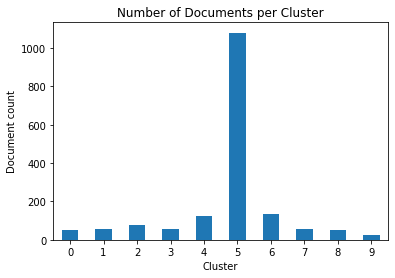

In [15]:
words_cluster_df.groupby('Cluster').count()[top_words[0]].plot.bar(rot=0).set(ylabel='Document count',title='Number of Documents per Cluster');

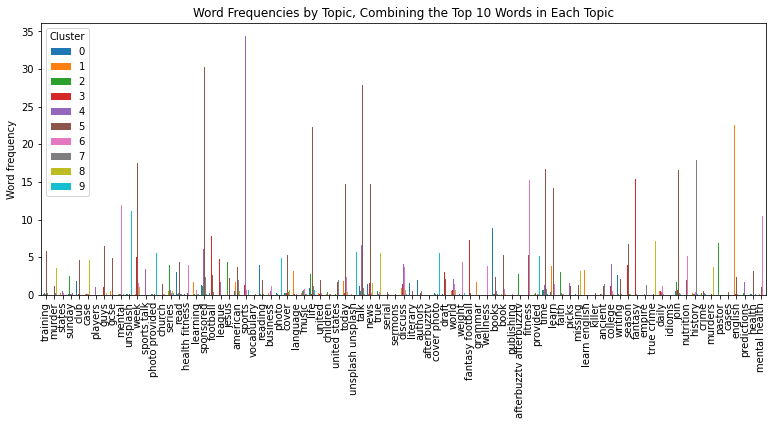

In [17]:
words_cluster_df.groupby('Cluster').sum().transpose().\
    plot.bar(figsize=(13,5), width=0.7).\
    set(ylabel='Word frequency', 
    title='Word Frequencies by Topic, Combining the Top {} Words in Each Topic'.format(10));

In [49]:
# get the show description to cluster association 

show_vs_cluster = {}
for name in podcasts:
    for k in range(n_clusters):
        n = set(all_keywords[name]).intersection(set([features[j] for j in order_centers[k][:20]]))
        if len(n) >= 10:
            if name not in show_vs_cluster:
                show_vs_cluster[name] = [k]
            else:
                show_vs_cluster[name].extend([k])

In [50]:
podcasts_with_cluster_assignments = []

for show_name in podcasts:
    try:
        #print(show_vs_cluster[show_name],show_name)
        podcasts_with_cluster_assignments.append([show_name,[features[k] for k in order_centers[show_vs_cluster[show_name][0]][0:10]]])
    except KeyError as ke:
        pass

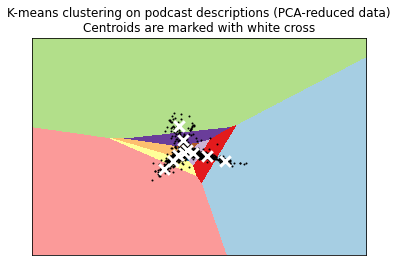

In [26]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

reduced_data = PCA(n_components=2).fit_transform(matrix_dense)
    #StandardScaler().fit_transform(matrix_dense))
kmeans = KMeans(init="k-means++", n_clusters=10, n_init=4)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.002  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=110,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on podcast descriptions (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()


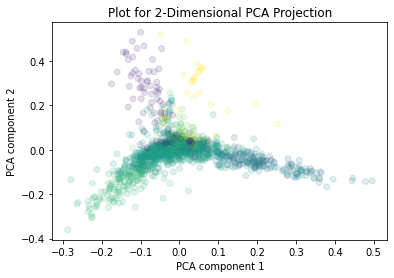

In [23]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

reduced_data = PCA(n_components=2,random_state=123).fit_transform(matrix_dense)
#fit_transform(StandardScaler().fit_transform(matrix_dense))

plt.scatter(reduced_data[:,0], reduced_data[:,1], c=words_cluster_df['Cluster'], 
            cmap='viridis', alpha=0.15)
plt.gca().set(title='Plot for 2-Dimensional PCA Projection', 
              xlabel='PCA component 1', ylabel='PCA component 2');